In [ ]:
!pip install -q nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.9 MB/s eta 0:00:00


In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from google.colab import files

In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
df = pd.read_csv('Test_Transcript_Manipulate.csv')

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_with_punctuation(text):
    tokens = nltk.word_tokenize(text.lower())
    #tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

def preprocess_cleaned(text):
    text = re.sub(r'[^\w\s]', '', text.lower())  # remove punctuation
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [ ]:
df['Text_with_punct'] = df['Text'].apply(preprocess_with_punctuation)

In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import pandas as pd
from tqdm import tqdm
import numpy as np

# Load GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Assuming your DataFrame is named `df` and column is `Text_with_punct`
texts = df['Text_with_punct'].tolist()
perplexities = []

# Function to compute perplexity for a single sentence
def compute_perplexity(text):
    encodings = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    input_ids = encodings.input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
    return torch.exp(loss).item()

# Compute perplexity for each frame
for text in tqdm(texts, desc="Computing Perplexities"):
    try:
        ppl = compute_perplexity(text)
    except:
        ppl = np.nan  # handle any tokenizer/model issues
    perplexities.append(ppl)

df['perplexity'] = perplexities

# Normalize to [0, 100] as completion label
# Higher perplexity → more semantic novelty → higher completion
valid_ppl = df['perplexity'].dropna()
min_ppl = valid_ppl.min()
max_ppl = valid_ppl.max()

# Avoid division by zero
df['completion_label'] = df['perplexity'].apply(
    lambda x: 100 * (x - min_ppl) / (max_ppl - min_ppl) if pd.notnull(x) else 0
)


Computing Perplexities: 100%|██████████| 69/69 [00:01<00:00, 48.75it/s]


In [ ]:
df

,Unnamed: 0,Frame,Timestamp,Text,Text_with_punct,perplexity,completion_label
0,0,1,"00:00:00,000 --> 00:00:19,320","Hello everyone, welcome to lecture 1 of C S 7 ...","hello everyone , welcome to lecture 1 of c s 7...",242.904099,16.259340
1,1,2,"00:00:19,320 --> 00:00:23,920",In today's lecture is going to be a bit non-te...,in today 's lecture is going to be a bit non-t...,50.614651,1.730285
2,2,3,"00:00:23,920 --> 00:00:29,240","concepts, we are going to talk about a brief o...","concepts , we are going to talk about a brief ...",54.866940,2.051581
3,3,4,"00:00:29,240 --> 00:00:35,120","So, we hear the terms artificial neural networ...","so , we hear the terms artificial neural netwo...",402.733612,28.335779
4,4,5,"00:00:35,120 --> 00:00:39,320",and I just wanted you to take you through the ...,and i just wanted you to take you through the ...,80.808464,4.011677
...,...,...,...,...,...,...,...
64,64,65,"00:06:08,520 --> 00:06:13,800",which I have mentioned on the bullet and there...,which i have mentioned on the bullet and there...,84.700722,4.305769
65,65,66,"00:06:13,800 --> 00:06:19,400",dates as crack as 1871s maybe I have got some ...,dates as crack as 1871s maybe i have got some ...,229.873825,15.274796
66,66,67,"00:06:19,400 --> 00:06:23,480",me if you think some of these portions need to...,me if you think some of these portions need to...,32.844219,0.387583
67,67,68,"00:06:23,480 --> 00:06:33,080",could provide me appropriate references for th...,could provide me appropriate references for th...,658.956360,47.695523


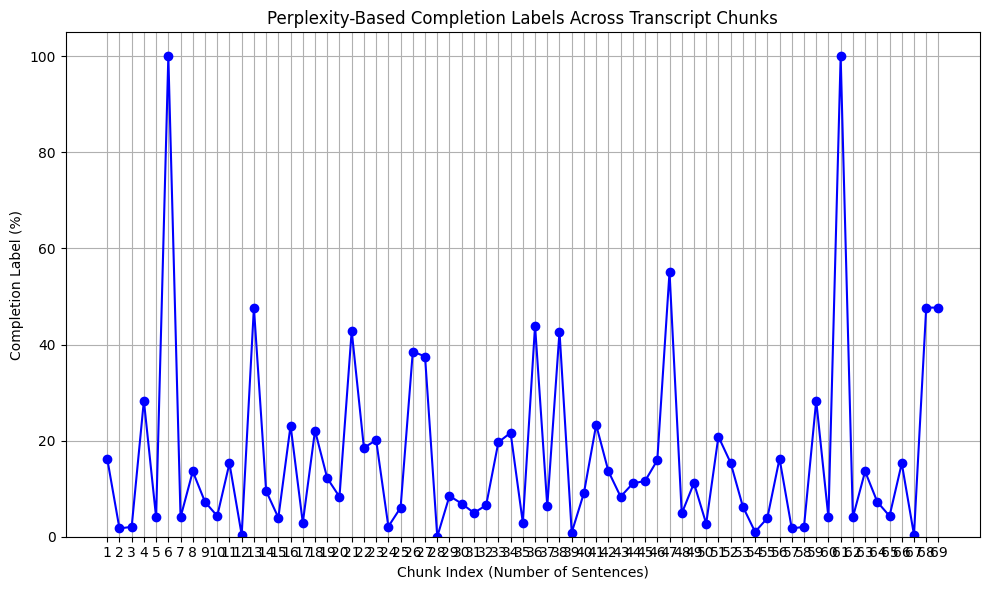

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(df.index + 1, df['completion_label'], marker='o', linestyle='-', color='blue')
plt.title('Perplexity-Based Completion Labels Across Transcript Chunks')
plt.xlabel('Chunk Index (Number of Sentences)')
plt.ylabel('Completion Label (%)')
plt.grid(True)
plt.ylim(0, 105)
plt.xticks(df.index + 1)
plt.tight_layout()
plt.show()